In [1]:
import numpy as np
import pandas as pd

import estimagic as em

# Numerical optimization

Using simple examples, this tutorial shows how to do an optimization with estimagic. More details on the topics covered here can be found in the [how to guides](../how_to_guides/index.rst).

## Basic usage of `minimize`

In [2]:
def sphere(params):
    return params @ params

In [3]:
res = em.minimize(
    criterion=sphere,
    params=np.arange(5),
    algorithm="scipy_lbfgsb",
)

res.params.round(5)

array([ 0., -0., -0., -0., -0.])

## `params` do not have to be vectors

In estimagic, params can by arbitrary [pytrees](https://jax.readthedocs.io/en/latest/pytrees.html). Examples are (nested) dictionaries of numbers, arrays and pandas objects. 

In [4]:
def dict_sphere(params):
    return params["a"] ** 2 + params["b"] ** 2 + (params["c"] ** 2).sum()

In [5]:
res = em.minimize(
    criterion=dict_sphere,
    params={"a": 0, "b": 1, "c": pd.Series([2, 3, 4])},
    algorithm="scipy_powell",
)

res.params

{'a': -6.821706323446569e-25,
 'b': 2.220446049250313e-16,
 'c': 0    8.881784e-16
 1    8.881784e-16
 2    1.776357e-15
 dtype: float64}

## The result contains all you need to know

In [6]:
res = em.minimize(
    criterion=dict_sphere,
    params={"a": 0, "b": 1, "c": pd.Series([2, 3, 4])},
    algorithm="scipy_neldermead",
)
res

Minimize with 5 free parameters terminated successfully after 805 criterion evaluations and 507 iterations.

The value of criterion improved from 30.0 to 1.6760003634613059e-16.

The scipy_neldermead algorithm reported: Optimization terminated successfully.

Independent of the convergence criteria used by scipy_neldermead, the strength of convergence can be assessed by the following criteria:

                             one_step     five_steps 
relative_criterion_change  1.968e-15***  2.746e-15***
relative_params_change     9.834e-08*    1.525e-07*  
absolute_criterion_change  1.968e-16***  2.746e-16***
absolute_params_change     9.834e-09**   1.525e-08*  

(***: change <= 1e-10, **: change <= 1e-8, *: change <= 1e-5. Change refers to a change between accepted steps. The first column only considers the last step. The second column considers the last five steps.)

## You can visualize the convergence

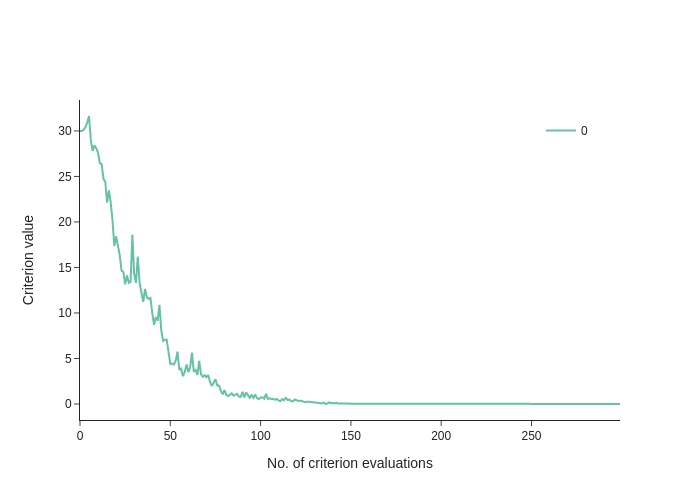

In [7]:
fig = em.criterion_plot(res, max_evaluations=300)
fig.show(renderer="png")

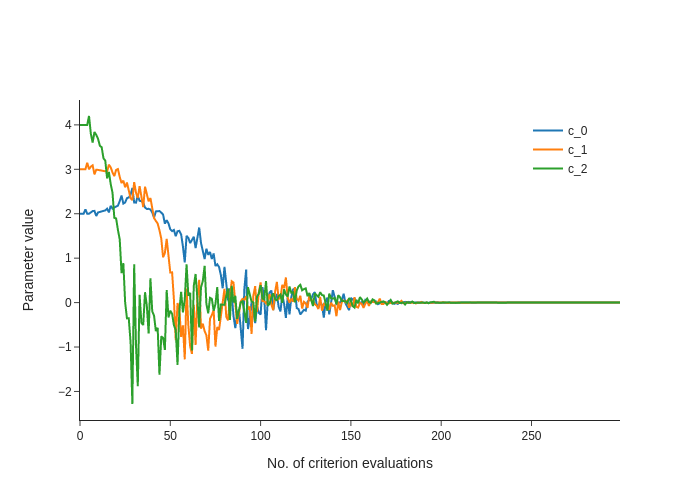

In [8]:
fig = em.params_plot(
    res,
    max_evaluations=300,
    # optionally select a subset of parameters to plot
    selector=lambda params: params["c"],
)
fig.show(renderer="png")

## There are many optimizers

If you install some optional dependencies, you can choose from a large (and growing) set of optimization algorithms -- all with the same interface!

For example, we wrap optimizers from `scipy.optimize`, `nlopt`, `cyipopt`, `pygmo`, `fides`, `tao` and others. 

We also have some optimizers that are not part of other packages. Examples are a `parallel Nelder-Mead` algorithm, The `BHHH` algorithm and a `parallel Pounders` algorithm.

See the full list [here](../how_to_guides/optimization/how_to_specify_algorithm_and_algo_options.rst)

## You can add bounds

In [9]:
res = em.minimize(
    criterion=sphere,
    params=np.arange(5),
    algorithm="scipy_lbfgsb",
    lower_bounds=np.arange(5) - 2,
    upper_bounds=np.array([10, 10, 10, np.inf, np.inf]),
)

res.params.round(5)

array([0., 0., 0., 1., 2.])

## You can fix parameters 

In [10]:
res = em.minimize(
    criterion=sphere,
    params=np.arange(5),
    algorithm="scipy_lbfgsb",
    constraints=[{"loc": [1, 3], "type": "fixed"}],
)

res.params.round(5)

array([ 0.,  1., -0.,  3.,  0.])

## Or impose other constraints

As an example, let's impose the constraint that the first three parameters are valid probabilities, i.e. they are between zero and one and sum to one:

In [11]:
res = em.minimize(
    criterion=sphere,
    params=np.array([0.1, 0.5, 0.4, 4, 5]),
    algorithm="scipy_lbfgsb",
    constraints=[{"loc": [0, 1, 2], "type": "probability"}],
)

res.params.round(5)

array([ 0.33334,  0.33333,  0.33333, -0.     ,  0.     ])

For a full overview of the constraints we support and the corresponding syntaxes, check out [the documentation](../how_to_guides/optimization/how_to_specify_constraints.rst).

Note that `"scipy_lbfgsb"` is not a constrained optimizer. If you want to know how we achieve this, check out [the explanations](../explanations/optimization/implementation_of_constraints.rst).

## There is also maximize

If you ever forgot to switch back the sign of your criterion function after doing a maximization with `scipy.optimize.minimize`, there is good news:

In [12]:
def upside_down_sphere(params):
    return -params @ params

In [13]:
res = em.maximize(
    criterion=upside_down_sphere,
    params=np.arange(5),
    algorithm="scipy_bfgs",
)

res.params.round(5)

array([ 0.,  0.,  0.,  0., -0.])

estimagic got your back.

## You can provide closed form derivatives

In [14]:
def sphere_gradient(params):
    return 2 * params

In [15]:
res = em.minimize(
    criterion=sphere,
    params=np.arange(5),
    algorithm="scipy_lbfgsb",
    derivative=sphere_gradient,
)
res.params.round(5)

array([ 0., -0., -0., -0., -0.])

## Or use parallelized numerical derivatives

In [16]:
res = em.minimize(
    criterion=sphere,
    params=np.arange(5),
    algorithm="scipy_lbfgsb",
    numdiff_options={"n_cores": 6},
)

res.params.round(5)

array([ 0., -0., -0., -0., -0.])

## Turn local optimizers global with multistart

In [17]:
res = em.minimize(
    criterion=sphere,
    params=np.arange(10),
    algorithm="scipy_neldermead",
    soft_lower_bounds=np.full(10, -5),
    soft_upper_bounds=np.full(10, 15),
    multistart=True,
    multistart_options={"convergence.max_discoveries": 5},
)
res.params.round(5)

array([ 0.,  0., -0., -0.,  0., -0.,  0., -0., -0., -0.])

## And plot the criterion history of all local optimizations

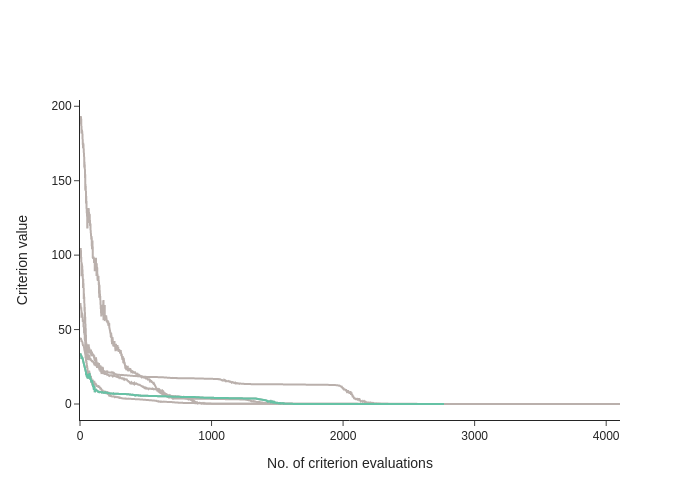

In [18]:
fig = em.criterion_plot(res)
fig.show(renderer="png")

## Exploit the structure of your optimization problem

Many estimation problems have a least-squares structure. If so, specialized optimizers that exploit this structure can be much faster than standard optimizers. Likewise, other problems might have, if not a least-squares structure, at least a sum-structure (e.g. likelihood functions) that can also be exploited by suitable optimizers.

If you define your criterion function a bit differently, you can seamlessly switch between least-squares, sum-structure and standard optimizers.

In [19]:
def general_sphere(params):
    contribs = params**2
    out = {
        # root_contributions are the least squares residuals.
        # if you square and sum them, you get the criterion value
        "root_contributions": params,
        # if you sum up contributions, you get the criterion value
        "contributions": contribs,
        # this is the standard output
        "value": contribs.sum(),
    }
    return out

In [20]:
res = em.minimize(
    criterion=general_sphere,
    params=np.arange(5),
    algorithm="pounders",
)
res.params.round(5)

array([-0.,  0.,  0.,  0., -0.])

## Using and reading persistent logging

For long-running and difficult optimizations, it can be worthwhile to store the progress in a persistent log file. You can do this by providing a path to the `logging` argument:

In [21]:
res = em.minimize(
    criterion=sphere,
    params=np.arange(5),
    algorithm="scipy_lbfgsb",
    logging="my_log.db",
    log_options={"if_database_exists": "replace"},
)

You can read the entries in the log file (while the optimization is still running or after it has finished) as follows:

In [22]:
reader = em.OptimizeLogReader("my_log.db")
reader.read_history().keys()

dict_keys(['params', 'criterion', 'runtime'])

For more information on what you can do with the log file and LogReader object, check out [the logging tutorial](../how_to_guides/optimization/how_to_use_logging.ipynb)

The persistent log file is always instantly synchronized when the optimizer tries a new parameter vector. This is very handy if an optimization has to be aborted and you want to extract the current status. It is also used by the  [estimagic dashboard](../how_to_guides/optimization/how_to_use_the_dashboard.rst). 

## Customize your optimizer

Most algorithms have a few optional arguments. Examples are convergence criteria or tuning parameters. You can find an overview of supported arguments [here](../how_to_guides/optimization/how_to_specify_algorithm_and_algo_options.rst).

In [23]:
algo_options = {
    "convergence.relative_criterion_tolerance": 1e-9,
    "stopping.max_iterations": 100_000,
}

res = em.minimize(
    criterion=sphere,
    params=np.arange(5),
    algorithm="scipy_lbfgsb",
    algo_options=algo_options,
)
res.params.round(5)

array([ 0., -0., -0., -0., -0.])